In [ ]:
import urllib
import gromacs as gmx
import nglview as nv
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mdrun=gmx.MDrunnerK8s()

def run(mpi=1,omp=2,gpus=1,**kwargs):
    mdrun.run(pre={'cores':omp*mpi,'mpi':mpi,'omp':omp,'gpus':gpus}, mdrunargs={**kwargs,'ntomp':omp},ncores=mpi)

In [ ]:
# big guy
# pdb='6pxm'
# mpi=4
# omp=4

# little toy
pdb='1l2y'
mpi=1
omp=2

# repex demo
pdb='6pxm'
mpi=8
omp=2

urllib.request.urlretrieve(f'https://files.rcsb.org/download/{pdb}.pdb',f'{pdb}.pdb')

In [ ]:
nv.show_file(f'{pdb}.pdb')

In [ ]:
gmx.pdb2gmx(f=pdb+'.pdb',o=pdb+'.gro',water='tip3p',ff='amber99',p=pdb+'.top',ignh=True)

In [7]:
gmx.editconf(f=pdb+'.gro',o=pdb+'-box.gro',c=True,d='1.5', bt='dodecahedron')

pod/asmsa-gmx-116-5lwdj condition met
              :-) GROMACS - gmx editconf, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx editconf -f 6pxm.gro -o 6pxm-box.gro -c -d 1.5 -bt dodecahedron



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 65112 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size : 12.227 12.226 12.222 (nm)
    diameter    : 13.403               (nm)
    center      : 13.313 13.312 13.312 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : -1.011 -1.010 -7.513 (nm)
new center      : 12.302 12.302  5.799 (nm)
new box vectors : 16.403 16.403 16.403 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  :3120.53               (nm^3)



Back Off! I just backed up 6pxm-box.gro to ./#6pxm-box.gro.1#

GROMACS reminds you: "As always in life, people want a simple answer... and it's always wrong." (Marie Daly)



(0, None, None)

In [8]:
gmx.solvate(cp=pdb+'-box.gro',cs='spc216.gro',o=pdb+'-solv.gro',p=pdb+'.top')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx solvate, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx solvate -cp 6pxm-box.gro -cs spc216.gro -o 6pxm-solv.gro -p 6pxm.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...
Generating solvent configuration
Will generate new solvent configuration of 9x9x7 boxes
Solvent box contains 333396 atoms in 111132 residues



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Removed 26736 solvent atoms due to solvent-solvent overlap
Removed 59430 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 82410 residues
Generated solvent containing 247230 atoms in 82410 residues
Writing generated configuration to 6pxm-solv.gro

Output configuration contains 312342 atoms in 86490 residues


Adding line for 82410 solvent molecules with resname (SOL) to topology file (6pxm.top)


Volume                 :     3120.53 (nm^3)
Density                :     1054.58 (g/l)
Number of solvent molecules:  82410   

Processing topology

Back Off! I just backed up 6pxm.top to ./#6pxm.top.1#

GROMACS reminds you: "You see it through a charmed medium: you can not discern that the gilding is slime and the silk draperies cobwebs; that the marble is sordid slate, and the polished woods mere refuse chips and scale bark." (Mr. Rochester in Jane Eyre by Charlotte Bronte)



(0, None, None)

In [9]:
with open('ions.mdp','w') as ions:
    ions.write("""\
; ions.mdp - used as input into grompp to generate ions.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme	= Verlet    ; Buffered neighbor searching 
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = cutoff    ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions
""")
    
gmx.grompp(f='ions.mdp',c=pdb+'-solv.gro',p=pdb+'.top',o='ions.tpr')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx grompp -f ions.mdp -c 6pxm-solv.gro -p 6pxm.top -o ions.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 0.5

NOTE 2 [file 6pxm.top, line 92]:
  System has non-zero total charge: -168.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html
  for discussion on how close it should be to an integer.



Number of degrees of freedom in T-Coupling group rest is 689793.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [fi

Setting the LD random seed to -8922641

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

Excluding 3 bonded neighbours molecule type 'Protein_chain_I'

Excluding 3 bonded neighbours molecule type 'Protein_chain_J'

Excluding 3 bonded neighbours molecule type 'Protein_chain_K'

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

Excluding 3 bonded neighbours molecule type 'Protein_chain_M'

Excluding 3 bonded neigh

(0, None, None)

In [10]:
gmx.select(s=pdb+'-solv.gro',on='solv.ndx',select='SOL')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx select, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx select -s 6pxm-solv.gro -on solv.ndx -select SOL




         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.




Back Off! I just backed up solv.ndx to ./#solv.ndx.1#
Analyzed topology coordinates

GROMACS reminds you: "Protons give an atom its identity, electrons its personality." (Bill Bryson)



(0, None, None)

In [11]:
gmx.genion(s='ions.tpr',n='solv.ndx',o=pdb+'-ions.gro',p=pdb+'.top',pname='NA',nname='CL',neutral=True)

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx genion, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx genion -s ions.tpr -n solv.ndx -o 6pxm-ions.gro -p 6pxm.top -pname NA -nname CL -neutral

Reading file ions.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file ions.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Group     0 (            SOL) has 247230 elements
There is one group in the index
Number of (3-atomic) solvent molecules: 82410

Back Off! I just backed up 6pxm.top to ./#6pxm.top.2#
Using random seed 2044721039.
Replacing solvent molecule 70640 (atom 277032) with NA
Replacing solvent molecule 10463 (atom 96501) with NA
Replacing solvent molecule 75125 (atom 290487) with NA
Replacing solvent molecule 38476 (atom 180540) with NA
Replacing solvent molecule 69587 (atom 273873) with NA
Replacing solvent molecule 78800 (atom 301512) 

Will try to add 168 NA ions and 0 CL ions.
Select a continuous group of solvent molecules

Processing topology
Replacing 168 solute molecules in topology file (6pxm.top)  by 168 NA and 0 CL ions.



GROMACS reminds you: "Push It Real Good" (Salt 'n' Pepa)



(0, None, None)

In [12]:
with open('minim.mdp','w') as m:
    m.write("""\
; minim.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.005          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

nstxout                 = 50         
nstvout                 = 0        
nstfout                 = 0
nstenergy               = 50         
""")
    
gmx.grompp(f='minim.mdp',c=pdb+'-ions.gro',p=pdb+'.top',o='em.tpr')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx grompp -f minim.mdp -c 6pxm-ions.gro -p 6pxm.top -o em.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group rest is 689289.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 2 [file minim.mdp]:
  This run will generate roughly 3599 Mb of data


There were 2 NOTEs

Back Off! I just backed up em.tpr to ./#em.tpr.1#

GROMACS reminds you: "You Look Better Upside Down" (Throwing Muses)



Setting the LD random seed to -706840577

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

Excluding 3 bonded neighbours molecule type 'Protein_chain_I'

Excluding 3 bonded neighbours molecule type 'Protein_chain_J'

Excluding 3 bonded neighbours molecule type 'Protein_chain_K'

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

Excluding 3 bonded neighbours molecule type 'Protein_chain_M'

Excluding 3 bonded nei

(0, None, None)

In [17]:
# can fail initially with k8s timeout etc., don't worry and retry
run(mpi=1,omp=4,deffnm='em',gpus=1)

job.batch/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb created
pod/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-8w68n condition met
pod/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-b66hw condition met


Unable to use a TTY - input is not a terminal or the right kind of file
                :-) GROMACS - gmx mdrun, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx mdrun -deffnm em -ntomp 4


Back Off! I just backed up em.log to ./#em.log.2#
Reading file em.tpr, VERSION 2024.3-plumed_2.10b (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI process

Non-default thread affinity set, disabling internal thread affinity

Using 4 OpenMP threads 


Back Off! I just backed up em.trr to ./#em.trr.2#

Back Off! I just backed up em.edr to ./#em.edr.2#

Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000

writing lowest energy coordinates.

Back Off

job.batch "gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb" deleted


In [18]:
gmx.select(s=pdb+'-ions.gro',on='protein.ndx',select='Protein')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx select, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx select -s 6pxm-ions.gro -on protein.ndx -select Protein




         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.




Back Off! I just backed up protein.ndx to ./#protein.ndx.2#
Analyzed topology coordinates

GROMACS reminds you: "Roses are read // Violets are blue // Unexpected '}' on line 32" (Anonymous)



(0, None, None)

In [19]:
gmx.trjconv(s=pdb+'-ions.gro',f='em.trr',n='protein.ndx',o='em-protein.xtc')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx trjconv, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx trjconv -s 6pxm-ions.gro -f em.trr -n protein.ndx -o em-protein.xtc

Will write xtc: Compressed trajectory (portable xdr format): xtc
Group     0 (        Protein) has 65112 elements
There is one group in the index
trr version: GMX_trn_file (single precision)
Reading frame       0 time   59.000   
Setting output precision to 0.001 (nm)

Back Off! I just backed up em-protein.xtc to ./#em-protein.xtc.1#
Reading frame      30 time 1955.000    ->  frame     29 time 1892.000       ->  frame     16 time 1071.000      

Last written: frame     32 time 2049.000


GROMACS reminds you: "FORTRAN, the infantile disorder, by now nearly 20 years old, is hopelessly inadequate for whatever computer application you have in mind today: it is now too clumsy, too risky, an

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output


(0, None, None)

In [20]:
tr=md.load('em-protein.xtc',top=pdb+'.gro')
nv.show_mdtraj(tr)

NGLWidget(max_frame=32)

In [29]:
eqsteps = 1000 # unrealistic, just speed up
with open('nvt.mdp','w') as nvt:
    nvt.write(f'''title                   = OPLS Lysozyme NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein
; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = {eqsteps}     ; 2 * 50000 = 100 ps
dt                      = 0.002     ; 2 fs
; Output control
nstxout                 = 500       ; save coordinates every 1.0 ps
nstvout                 = 500       ; save velocities every 1.0 ps
nstenergy               = 500       ; save energies every 1.0 ps
nstlog                  = 500       ; update log file every 1.0 ps
; Bond parameters
continuation            = no        ; first dynamics run
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb                = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.0       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.16      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = Protein Non-Protein   ; two coupling groups - more accurate
tau_t                   = 0.1     0.1           ; time constant, in ps
ref_t                   = 300     300           ; reference temperature, one for each group, in K
; Pressure coupling is off
pcoupl                  = no        ; no pressure coupling in NVT
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = yes       ; assign velocities from Maxwell distribution
gen_temp                = 300       ; temperature for Maxwell distribution
gen_seed                = -1        ; generate a random seed
''')

In [30]:
gmx.grompp(f="nvt.mdp",c="em.gro",r="em.gro",p=pdb+'.top',o="nvt.tpr")

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx grompp -f nvt.mdp -c em.gro -r em.gro -p 6pxm.top -o nvt.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

NOTE 1 [file nvt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 NOTE

Back Off! I just backed up nvt.tpr to ./#nvt.tpr.2#


Setting the LD random seed to -151265766

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule ty


GROMACS reminds you: "Fly to the Court of England and Unfold" (Macbeth, Act 3, Scene 6, William Shakespeare)



(0, None, None)

In [31]:
run(mpi=mpi,omp=omp,deffnm='nvt',gpus=1)

job.batch/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb created
pod/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-5bqsz condition met


Unable to use a TTY - input is not a terminal or the right kind of file
                :-) GROMACS - gmx mdrun, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx mdrun -deffnm nvt -ntomp 2


Back Off! I just backed up nvt.log to ./#nvt.log.2#
Reading file nvt.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Changing nstlist from 10 to 80, rlist from 1.001 to 1.15

On host gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-5bqsz 1 GPU selected for this run.
Mapping of GPU IDs to the 8 GPU tasks in the 8 ranks on this node:
  PP:0,PP:0,PP:0,PP:0,PP:0,PP:0,PP:0,PP:0
PP tasks will do (non-perturbed) short-ranged and most bonded interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 8 MPI processes

Non-default thread affinity set, disabling internal thread affinity

Using 2 OpenMP threads per MPI process


Back Off! I just backed up nvt.trr to ./#nvt.trr.2#



job.batch "gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb" deleted


In [32]:
gmx.energy(f='nvt.edr',o='press.xvg',input='Pressure')
#gmx.energy(f='nvt.edr',o='dens.xvg',input='Density')
gmx.energy(f='nvt.edr',o='temp.xvg',input='Temperature')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx energy, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx energy -f nvt.edr -o press.xvg

Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Vir-XX        
 21  Vir-XY          22  Vir-XZ          23  V


Statistics over 1001 steps [ 0.0000 through 2.0000 ps ], 1 data sets
All statistics are over 11 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -492.512         --    1019.86    2133.92  (bar)


pod/asmsa-gmx-116-5lwdj condition met



Statistics over 1001 steps [ 0.0000 through 2.0000 ps ], 1 data sets
All statistics are over 11 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                  290.12         --    17.2279    23.0937  (K)


               :-) GROMACS - gmx energy, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx energy -f nvt.edr -o temp.xvg

Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Vir-XX        
 21  Vir-XY          22  Vir-XZ          23  Vir-YX          24  Vir-YY        
 25  

(0, None, None)

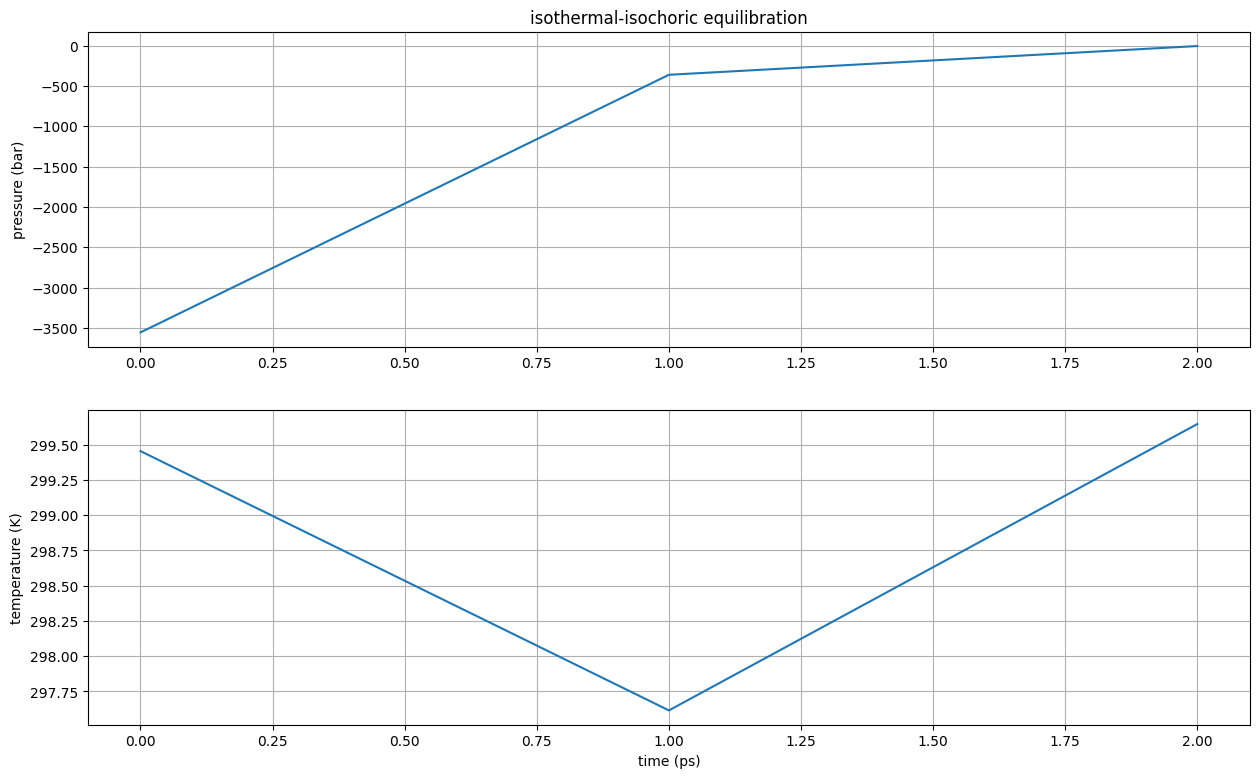

In [33]:
temp = np.loadtxt('temp.xvg',comments=['#','@'])
press = np.loadtxt('press.xvg',comments=['#','@'])

plt.figure(figsize=(15,9))
plt.subplot(211)
plt.plot(press[:,0],press[:,1])
plt.title('isothermal-isochoric equilibration')
plt.grid()
#plt.xlabel('time (ps)')
plt.ylabel("pressure (bar)")


plt.subplot(212)
plt.xlabel('time (ps)')
plt.ylabel('temperature (K)')
plt.grid()
plt.plot(temp[:,0],temp[:,1])

plt.show()

In [34]:
with open('npt.mdp','w') as npt:
    npt.write(f'''define                  = -DPOSRES  ; position restrain the protein
; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = {eqsteps}     ; 2 * 50000 = 100 ps
dt                      = 0.002     ; 2 fs
; Output control
nstxout                 = 500       ; save coordinates every 1.0 ps
nstvout                 = 500       ; save velocities every 1.0 ps
nstenergy               = 500       ; save energies every 1.0 ps
nstlog                  = 500       ; update log file every 1.0 ps
; Bond parameters
continuation            = yes       ; Restarting after NVT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 20 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.0       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.16      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = Protein Non-Protein   ; two coupling groups - more accurate
tau_t                   = 0.1     0.1           ; time constant, in ps
ref_t                   = 300     300           ; reference temperature, one for each group, in K
; Pressure coupling is on
; ljocha pcoupl                  = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupl = C-rescale
pcoupltype              = isotropic             ; uniform scaling of box vectors
; ljocha tau_p                   = 2.0                   ; time constant, in ps
tau_p = 5.0
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling        = com
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 
''')

In [35]:
gmx.grompp(f="npt.mdp",c="nvt.gro",r="nvt.gro",p=pdb+'.top',o="npt.tpr")

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -p 6pxm.top -o npt.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

NOTE 1 [file npt.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 NOTE

Back Off! I just backed up npt.tpr to ./#npt.tpr.1#


Setting the LD random seed to -11749441

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule typ


GROMACS reminds you: "After a few talks we usually sit down to do some work... or drinking." (Mike Klein)



(0, None, None)

In [36]:
run(mpi=mpi,omp=omp,gpus=1,deffnm='npt')

job.batch/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb created
pod/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-4kzf5 condition met


Unable to use a TTY - input is not a terminal or the right kind of file
                :-) GROMACS - gmx mdrun, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx mdrun -deffnm npt -ntomp 2


Back Off! I just backed up npt.log to ./#npt.log.1#
Reading file npt.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Changing nstlist from 10 to 80, rlist from 1.001 to 1.15

On host gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-4kzf5 1 GPU selected for this run.
Mapping of GPU IDs to the 8 GPU tasks in the 8 ranks on this node:
  PP:0,PP:0,PP:0,PP:0,PP:0,PP:0,PP:0,PP:0
PP tasks will do (non-perturbed) short-ranged and most bonded interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 8 MPI processes

Non-default thread affinity set, disabling internal thread affinity

Using 2 OpenMP threads per MPI process


Back Off! I just backed up npt.trr to ./#npt.trr.1#



job.batch "gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb" deleted


In [37]:
gmx.energy(f='npt.edr',o='press.xvg',input='Pressure')
gmx.energy(f='npt.edr',o='dens.xvg',input='Density')
gmx.energy(f='npt.edr',o='temp.xvg',input='Temperature')

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx energy, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx energy -f npt.edr -o press.xvg

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Box-X         
 21  Box-Y           22  Box-Z           23  V


Statistics over 1001 steps [ 0.0000 through 2.0000 ps ], 1 data sets
All statistics are over 11 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -130.283         --    211.592    527.749  (bar)


pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx energy, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx energy -f npt.edr -o dens.xvg

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Box-X         
 21  Box-Y           22  Box-Z           23  Vo


Statistics over 1001 steps [ 0.0000 through 2.0000 ps ], 1 data sets
All statistics are over 11 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                      1040.2         --     1.2008    3.21852  (kg/m^3)


pod/asmsa-gmx-116-5lwdj condition met



Statistics over 1001 steps [ 0.0000 through 2.0000 ps ], 1 data sets
All statistics are over 11 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                  300.08         --   0.654652  -0.551248  (K)


               :-) GROMACS - gmx energy, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx energy -f npt.edr -o temp.xvg

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Per.-Imp.-Dih.
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Box-X         
 21  Box-Y           22  Box-Z           23  Volume          24  Density       
 25  

(0, None, None)

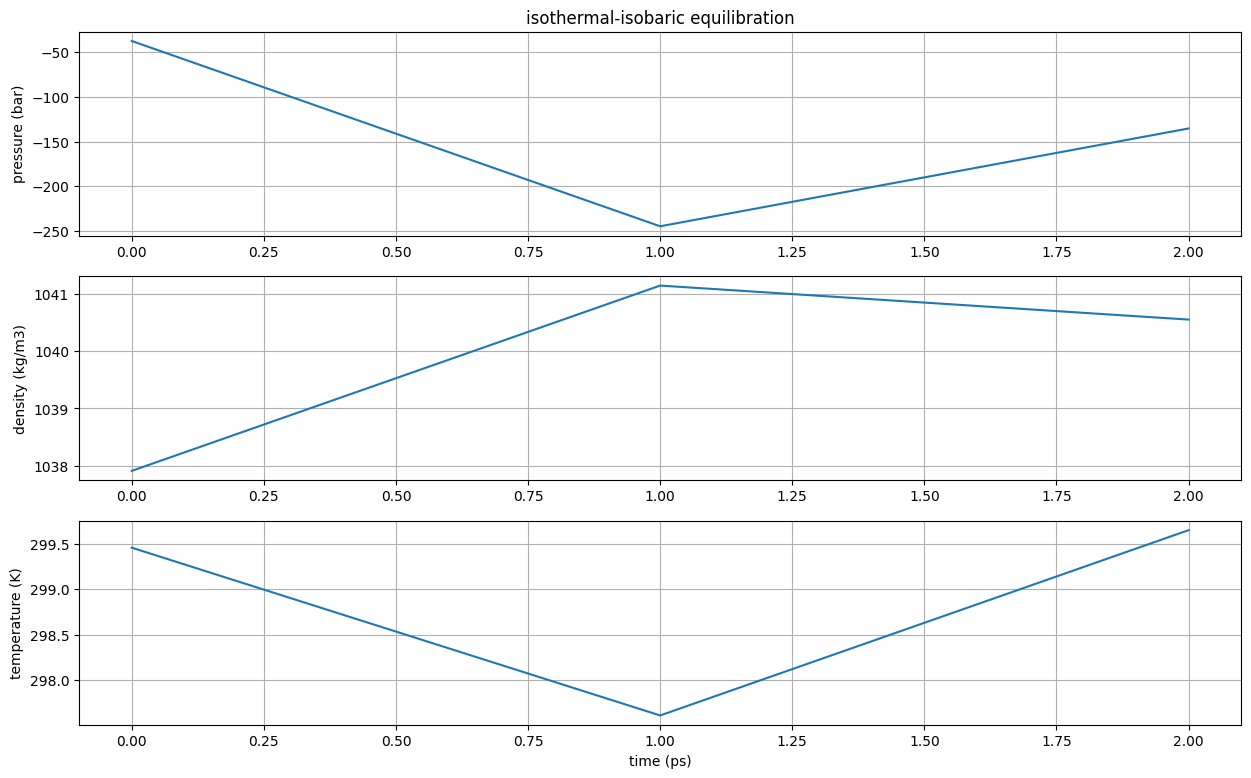

In [38]:
temp = np.loadtxt('temp.xvg',comments=['#','@'])
press = np.loadtxt('press.xvg',comments=['#','@'])
dens = np.loadtxt('dens.xvg',comments=['#','@'])

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.plot(press[:,0],press[:,1])
plt.title('isothermal-isobaric equilibration')
plt.grid()
#plt.xlabel('time (ps)')
plt.ylabel("pressure (bar)")

plt.subplot(312)
plt.ylabel('density (kg/m3)')
plt.grid()
plt.plot(dens[:,0],dens[:,1])

plt.subplot(313)
plt.xlabel('time (ps)')
plt.ylabel('temperature (K)')
plt.grid()
plt.plot(temp[:,0],temp[:,1])

plt.show()

In [39]:
def write_mdp(file,nsteps,ref_t):
    with open(file,'w') as mdp:
        mdp.write(f'''integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
; Output control
nstxout                 = 0         ; suppress bulky .trr file by specifying 
nstvout                 = 0         ; 0 for output frequency of nstxout,
nstfout                 = 0         ; nstvout, and nstfout
nstenergy               = 5000      ; save energies every 10.0 ps
nstlog                  = 5000      ; update log file every 10.0 ps
nstxout-compressed      = 5000      ; save compressed coordinates every 10.0 ps
compressed-x-grps       = Protein    
; Bond parameters
continuation            = yes       ; Restarting after NPT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Neighborsearching
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 20 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.0       ; short-range van der Waals cutoff (in nm)
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.16      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = Protein Non-Protein   ; two coupling groups - more accurate
tau_t                   = 0.1     0.1           ; time constant, in ps
ref_t                   = {ref_t}     {ref_t}           ; reference temperature, one for each group, in K
; Pressure coupling is on
pcoupl                  = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 2.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Dispersion correction
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 
nsteps = {nsteps}
''')

In [40]:
time = 100 #ps
nsteps = time * 500 # XXX: dt = 0.002
ref_t = 300

write_mdp('md.mdp',nsteps,ref_t)

In [ ]:
gmx.grompp(f="md.mdp",c="npt.gro",r="npt.gro",p=pdb+'.top',o="md.tpr")

In [ ]:
run(mpi=mpi,omp=omp,deffnm='md')

In [ ]:
gmx.trjconv(f='md.xtc',s=pdb+'-box.gro',pbc='nojump',input='Protein Protein'.split(),o='pbc.xtc')

In [ ]:
gmx.trjconv(f='pbc.xtc',s=pdb+'-box.gro',fit='rot+trans',input='Protein Protein'.split(),o='fit.xtc')

In [ ]:
tr = md.load('fit.xtc',top=f'{pdb}-box.gro')
nv.show_mdtraj(tr)

In [ ]:
# Replica exchange 

In [43]:
for rep in range(mpi):
    %mkdir rep_{rep}
    %cd rep_{rep}
    write_mdp('md.mdp',nsteps,ref_t + 10*rep)
    gmx.grompp(f="md.mdp",c="../npt.gro",r="../npt.gro",p='../'+pdb+'.top',o="md.tpr")
    %cd -
    

/home/jovyan/jupyterhub-gmx/rep_0


pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_0
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "Three Little Fonzies" (Pulp Fiction)



Setting the LD random seed to -1077936275

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule t

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_1
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "I Was Born to Have Adventure" (F. Zappa)



Setting the LD random seed to -688141369

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule ty

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_2
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "The soul? There's nothing but chemistry here" (Breaking Bad)



Setting the LD random seed to -2228361

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_3
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "Those people who think they know everything are a great annoyance to those of us who do." (Isaac Asimov)



Setting the LD random seed to -642908181

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule ty

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_4
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "Every revolutionary idea seems to evoke three stages of reaction. They may be summed up by the phrases: (1) It's completely impossible. (2) It's possible, but not worth doing. (3) I said it was a good idea all along." (Arthur C. Clarke)



Setting the LD random seed to -151790721

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule ty

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_5
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "I know poetry is not dead, nor genius lost; nor has Mammon gained power over either, to bind or slay; they will both assert their existence, their presence, their liberty and strength again one day." (Jane Eyre in Jane Eyre by Charlotte Bronte)



Setting the LD random seed to -5473923

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_6
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75

GROMACS reminds you: "When I asked a younger colleague at the university how he had been able to change his research field several times within a decade or so, he answered: "It's just a question of new software"" (Paul Verhaeghe)



Setting the LD random seed to -318657

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 

pod/asmsa-gmx-116-5lwdj condition met
               :-) GROMACS - gmx grompp, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx/rep_7
Command line:
  gmx grompp -f md.mdp -c ../npt.gro -r ../npt.gro -p ../6pxm.top -o md.tpr

Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group Protein is 162983.25
Number of degrees of freedom in T-Coupling group non-Protein is 493953.75


Setting the LD random seed to 2147347143

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_C'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_D'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_E'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_F'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_G'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_H'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule ty


GROMACS reminds you: "Bad As This Shit Is, This Shit Ain't As Bad As You Think It Is." (Jackie Brown)



In [ ]:
run(mpi=mpi,omp=omp,gpus=1,deffnm='md',multidir=[ f'rep_{rep}' for rep in range(mpi)],replex=100)

job.batch/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb created
pod/gmx-f102657d-87a5-44ca-9e8c-603a6851a7bb-98vjl condition met


Unable to use a TTY - input is not a terminal or the right kind of file
                :-) GROMACS - gmx mdrun, 2024.3-plumed_2.10b (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/jupyterhub-gmx
Command line:
  gmx mdrun -deffnm md -ntomp 2 -multidir rep_0 rep_1 rep_2 rep_3 rep_4 rep_5 rep_6 rep_7 -replex 100

Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Reading file md.tpr, VERSION 2024.3-plumed_2.10b (single precision)
Changing nstlist from 10 to 80, rlist from 1.001 to 1.162

Changing nstlist from 10 to 80